In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import time
from google.colab import files

In [3]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
set_seed()

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

In [6]:
train_set = ImageFolder(root='train//', transform=transform)
validate_set = ImageFolder(root='valid//', transform=transform)
test_set = ImageFolder(root='test//', transform=transform)

In [7]:
class_names = train_set.classes
num_labels = len(class_names)
print(class_names)
print(num_labels)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
10


In [8]:
data_loader = DataLoader(train_set, batch_size=64, num_workers=2, pin_memory=True, shuffle=True)
data_loader_val = DataLoader(validate_set, batch_size=64, num_workers=2, pin_memory=True, shuffle=False)
data_loader_test = DataLoader(test_set, batch_size=64, num_workers=2, shuffle=False)

In [9]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Should return 0 (or GPU index)
print(torch.cuda.get_device_name(0))  # Should return GPU name (e.g., Tesla T4)}

True
0
Tesla T4


# DenseNet121 with 30-shot learning

In [10]:
from torchvision.models import densenet121

In [11]:
model = densenet121(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 84.0MB/s]


In [12]:
model.classifier = nn.Identity()

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
model = model.to(device)

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [16]:
def euclidean_dist(x, y):
    """
    We compute euclidean distance (between tensors x, y)
    Args:
        x: Tensor of shape (n, d).
        y: Tensor of shape (m, d).
    Returns:
        dist: Tensor of shape (n, m).
    """
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    return torch.pow(x - y, 2).sum(2)

In [17]:
def sample_support_query_set(dataset, n_way, k_shot, n_query):
    """
    We sample from the dataset a support set and a query set for the few-shot.
    Args:
        dataset: Dataset to sample from.
        n_way: Number of classes.
        k_shot: Number of support examples per class.
        n_query: Number of query examples per class.
    Returns:
        support_set: Tensor of shape (n_way, k_shot, C, H, W).
        query_set: Tensor of shape (n_way, n_query, C, H, W).
    """
    classes = np.random.choice(len(dataset.classes), n_way, replace=False)
    support_set = []
    query_set = []
    for cls in classes:
        indices = np.where(np.array(dataset.targets) == cls)[0]
        selected = np.random.choice(indices, k_shot + n_query, replace=False)
        support_set.append([dataset[i][0] for i in selected[:k_shot]])
        query_set.append([dataset[i][0] for i in selected[k_shot:]])
    support_set = torch.stack([x for cls in support_set for x in cls]).view(n_way, k_shot, *support_set[0][0].shape)
    query_set = torch.stack([x for cls in query_set for x in cls]).view(n_way, n_query, *query_set[0][0].shape)
    return support_set, query_set

In [18]:
import torch.nn.functional as F

In [19]:


def train(model, train_set, n_way, k_shot, n_query, device, optimizer):
    """
    We're training the model on the training set.
    Args:
        model: The model to train.
        train_set: Training dataset.
        n_way: Number of classes.
        k_shot: Number of support examples per class.
        n_query: Number of query examples per class.
        device: Previously stated device.
        optimizer: Optimizer for training.
    Returns:
        avg_loss: Average training loss.
        avg_acc: Average training accuracy.
    """
    model.train()
    total_loss = 0
    total_acc = 0
    num_episodes = 100  # Number of training episodes

    for _ in range(num_episodes):
        # First we sample support and query sets
        support_set, query_set = sample_support_query_set(train_set, n_way, k_shot, n_query)
        support_set = support_set.to(device)
        query_set = query_set.to(device)

        # Now we compute embeddings
        support_embeddings = model(support_set.view(-1, *support_set.shape[2:])).view(n_way, k_shot, -1)
        query_embeddings = model(query_set.view(-1, *query_set.shape[2:])).view(n_way, n_query, -1)

        # The prototypes, which are the mean of support embeddings
        prototypes = support_embeddings.mean(dim=1)

        # Now compute distances between query embeddings and prototypes
        dists = euclidean_dist(query_embeddings.view(-1, query_embeddings.shape[-1]), prototypes)
        log_p_y = F.log_softmax(-dists, dim=1)

        # Create target labels
        target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long().to(device)
        target_inds = target_inds.view(-1)

        # Compute loss and accuracy
        loss = -log_p_y.gather(1, target_inds.unsqueeze(1)).squeeze().mean()
        _, predictions = torch.max(log_p_y, 1)
        acc = torch.eq(predictions, target_inds).float().mean()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        total_loss += loss.item()
        total_acc += acc.item()

    # Compute average loss and accuracy
    avg_loss = total_loss / num_episodes
    avg_acc = total_acc / num_episodes * 100
    return avg_loss, avg_acc

In [20]:
def validate(model, val_set, n_way, k_shot, n_query, device):
    """
    Validating the model on the valid set.
    Args:
        model: The trained model.
        val_set: Valid dataset.
        n_way: Number of classes.
        k_shot: Number of support examples per class.
        n_query: Number of query examples per class.
        device: Device.
    Returns:
        avg_loss: Average validation loss.
        avg_acc: Average validation accuracy.
    """
    model.eval()
    total_loss = 0
    total_acc = 0
    num_episodes = 100  # Number of validation episodes

    with torch.no_grad():
        for _ in range(num_episodes):
            # Sample support and query sets
            support_set, query_set = sample_support_query_set(val_set, n_way, k_shot, n_query)
            support_set = support_set.to(device)
            query_set = query_set.to(device)

            # Compute embeddings
            support_embeddings = model(support_set.view(-1, *support_set.shape[2:])).view(n_way, k_shot, -1)
            query_embeddings = model(query_set.view(-1, *query_set.shape[2:])).view(n_way, n_query, -1)

            # Compute prototypes (mean of support embeddings)
            prototypes = support_embeddings.mean(dim=1)

            # Compute distances between query embeddings and prototypes
            dists = euclidean_dist(query_embeddings.view(-1, query_embeddings.shape[-1]), prototypes)
            log_p_y = F.log_softmax(-dists, dim=1)

            # Create target labels
            target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long().to(device)
            target_inds = target_inds.view(-1)

            # Compute loss and accuracy
            loss = -log_p_y.gather(1, target_inds.unsqueeze(1)).squeeze().mean()
            _, predictions = torch.max(log_p_y, 1)
            acc = torch.eq(predictions, target_inds).float().mean()

            # Accumulate loss and accuracy
            total_loss += loss.item()
            total_acc += acc.item()

    # Compute average loss and accuracy
    avg_loss = total_loss / num_episodes
    avg_acc = total_acc / num_episodes * 100
    return avg_loss, avg_acc

In [21]:
def test(model, test_set, n_way, k_shot, n_query, device):
    """
    Testing the model on the test set.
    Args:
        model: The trained model.
        test_set: Test dataset.
        n_way: Number of classes.
        k_shot: Number of support examples per class.
        n_query: Number of query examples per class.
        device: device
    Returns:
        avg_loss: Average test loss.
        avg_acc: Average test accuracy.
        all_predictions: List of all predicted labels.
        all_targets: List of all ground truth labels.
    """
    model.eval()
    total_loss = 0
    total_acc = 0
    num_episodes = 100  # Number of test episodes
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for _ in range(num_episodes):
            # Sample support and query sets
            support_set, query_set = sample_support_query_set(test_set, n_way, k_shot, n_query)
            support_set = support_set.to(device)
            query_set = query_set.to(device)

            # Compute embeddings
            support_embeddings = model(support_set.view(-1, *support_set.shape[2:])).view(n_way, k_shot, -1)
            query_embeddings = model(query_set.view(-1, *query_set.shape[2:])).view(n_way, n_query, -1)

            # Compute prototypes (mean of support embeddings)
            prototypes = support_embeddings.mean(dim=1)

            # Compute distances between query embeddings and prototypes
            dists = euclidean_dist(query_embeddings.view(-1, query_embeddings.shape[-1]), prototypes)
            log_p_y = F.log_softmax(-dists, dim=1)

            # Create target labels
            target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long().to(device)
            target_inds = target_inds.view(-1)

            # Compute loss and accuracy
            loss = -log_p_y.gather(1, target_inds.unsqueeze(1)).squeeze().mean()
            _, predictions = torch.max(log_p_y, 1)
            acc = torch.eq(predictions, target_inds).float().mean()

            # Accumulate loss and accuracy
            total_loss += loss.item()
            total_acc += acc.item()

            # Store predictions and targets (we "move" GPU tensor to CPU, because it doesn't work otherwise with numpy)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(target_inds.cpu().numpy())

    # Compute average loss and accuracy
    avg_loss = total_loss / num_episodes
    avg_acc = total_acc / num_episodes * 100
    return avg_loss, avg_acc, all_predictions, all_targets

In [22]:
episode_batches = 30
n_way = 10
k_shot = 30
n_query = 50

In [23]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [24]:
for batch in range(episode_batches):

    train_loss, train_acc = train(model, train_set, n_way, k_shot, n_query, device, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f"After {100 * (batch + 1)} episodes, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

    val_loss, val_acc = validate(model, validate_set, n_way, k_shot, n_query, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"After {100 * (batch + 1)} episodes, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

After 100 episodes, Train Loss: 3.7841, Train Accuracy: 36.24%
After 100 episodes, Validation Loss: 1.5238, Validation Accuracy: 45.25%
After 200 episodes, Train Loss: 1.3855, Train Accuracy: 50.67%
After 200 episodes, Validation Loss: 1.5100, Validation Accuracy: 52.12%
After 300 episodes, Train Loss: 1.2489, Train Accuracy: 55.76%
After 300 episodes, Validation Loss: 1.2113, Validation Accuracy: 56.51%
After 400 episodes, Train Loss: 1.0816, Train Accuracy: 61.26%
After 400 episodes, Validation Loss: 1.1650, Validation Accuracy: 59.79%
After 500 episodes, Train Loss: 0.9809, Train Accuracy: 65.36%
After 500 episodes, Validation Loss: 1.0926, Validation Accuracy: 62.26%
After 600 episodes, Train Loss: 0.9826, Train Accuracy: 65.67%
After 600 episodes, Validation Loss: 1.1281, Validation Accuracy: 62.53%
After 700 episodes, Train Loss: 0.9717, Train Accuracy: 65.60%
After 700 episodes, Validation Loss: 1.2621, Validation Accuracy: 56.51%
After 800 episodes, Train Loss: 1.0238, Train Ac

In [25]:
test_loss, test_acc, test_predictions, test_targets = test(model, test_set, n_way, k_shot, n_query, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 1.0198, Test Accuracy: 64.54%


In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [27]:
def plot_confusion_matrix(targets, predictions, class_names):
    """
    Plots a confusion matrix.
    Args:
        targets: Ground truth labels.
        predictions: Predicted labels.
        class_names: List of class names.
    """
    cm = confusion_matrix(targets, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

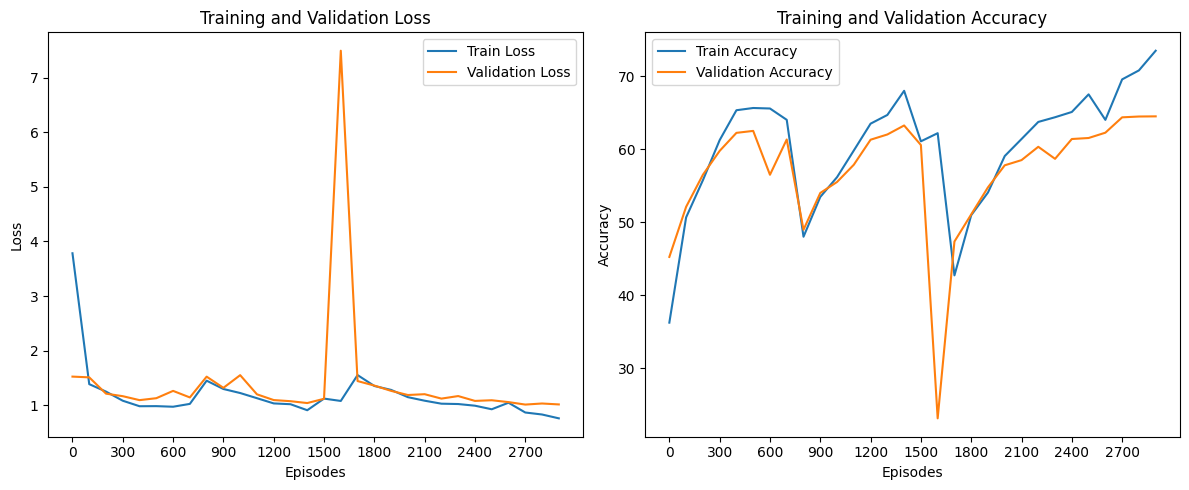

In [28]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
epochs = range(len(train_losses))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xticks(epochs[::len(epochs)//10], [int(x*100) for x in epochs[::len(epochs)//10]])  # Multiply x labels by 100
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xticks(epochs[::len(epochs)//10], [int(x*100) for x in epochs[::len(epochs)//10]])  # Multiply x labels by 100
plt.xlabel("Episodes")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

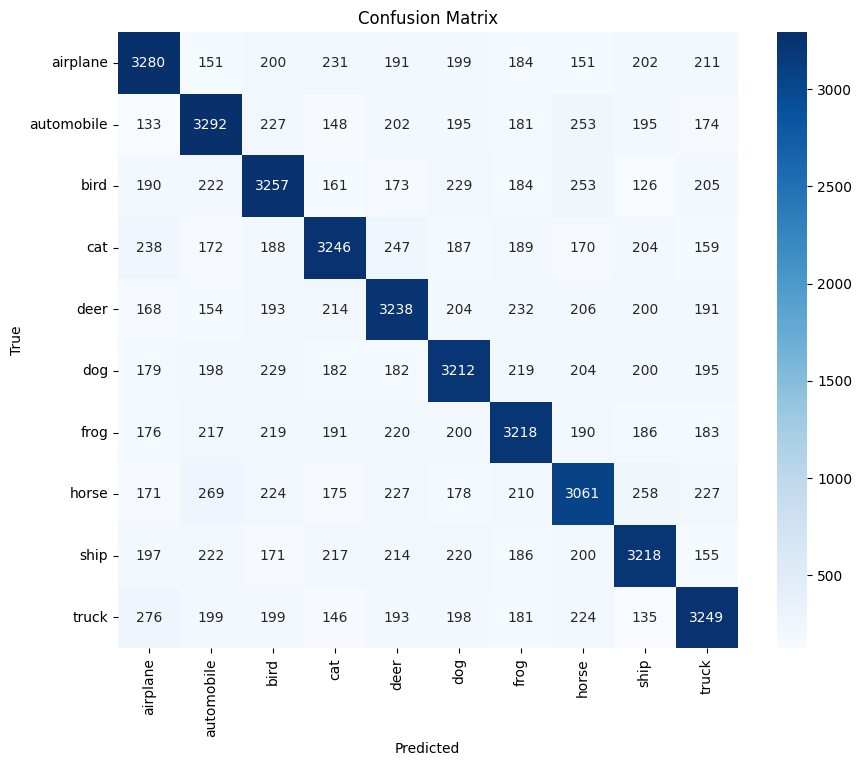

In [29]:
plot_confusion_matrix(test_targets, test_predictions, class_names)

In [30]:
torch.save(model.state_dict(), "fewshot_densenet121_model.pth")

In [31]:
files.download("fewshot_densenet121_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.load_state_dict(torch.load("fewshot_densenet121_model.pth"))

<ipython-input-26-c3a2fca51311>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fewshot_densenet121_model.pth"))


<All keys matched successfully>

In [32]:
import os
import shutil
from torchvision import datasets

# Let's reduce the training set to 33%

In [50]:
model_reduced2 = densenet121(pretrained=True)

In [51]:
model_reduced2.classifier = nn.Identity()

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [53]:
model_reduced2 = model_reduced2.to(device)

In [54]:
optimizer = torch.optim.AdamW(model_reduced2.parameters(), lr=0.001)

In [55]:
reduced2_train_indices = []

In [56]:
targets = np.array(train_set.targets)

In [57]:
original_train_dir = 'train'
reduced2_train_dir = 'reduced2_train'

In [58]:
os.makedirs(reduced2_train_dir, exist_ok=True)

In [59]:
num2_samples_per_class = 3000

In [60]:
for class_idx in range(len(train_set.classes)):
    class_indices = np.where(targets == class_idx)[0]
    selected_indices = np.random.choice(class_indices, size=num2_samples_per_class, replace=False)

    class_name = train_set.classes[class_idx]
    class_dir = os.path.join(reduced2_train_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

    for idx in selected_indices:
        src_path, _ = train_set.samples[idx]
        dst_path = os.path.join(class_dir, os.path.basename(src_path))
        shutil.copy(src_path, dst_path)

In [61]:
reduced2_train_set = ImageFolder(root='reduced2_train//', transform=transform)

In [62]:
reduced2_data_loader = DataLoader(reduced2_train_set, batch_size=64, num_workers=2, pin_memory=True, shuffle=True)

In [63]:
reduced2_train_losses = []
reduced2_train_accuracies = []
reduced2_val_losses = []
reduced2_val_accuracies = []

In [64]:


def train(model, train_set, n_way, k_shot, n_query, device, optimizer):
    """
    We're training the model on the training set.
    Args:
        model: The model to train.
        train_set: Training dataset.
        n_way: Number of classes.
        k_shot: Number of support examples per class.
        n_query: Number of query examples per class.
        device: Previously stated device.
        optimizer: Optimizer for training.
    Returns:
        avg_loss: Average training loss.
        avg_acc: Average training accuracy.
    """
    model.train()
    total_loss = 0
    total_acc = 0
    num_episodes = 100  # Number of training episodes

    for _ in range(num_episodes):
        # First we sample support and query sets
        support_set, query_set = sample_support_query_set(train_set, n_way, k_shot, n_query)
        support_set = support_set.to(device)
        query_set = query_set.to(device)

        # Now we compute embeddings
        support_embeddings = model(support_set.view(-1, *support_set.shape[2:])).view(n_way, k_shot, -1)
        query_embeddings = model(query_set.view(-1, *query_set.shape[2:])).view(n_way, n_query, -1)

        # The prototypes, which are the mean of support embeddings
        prototypes = support_embeddings.mean(dim=1)

        # Now compute distances between query embeddings and prototypes
        dists = euclidean_dist(query_embeddings.view(-1, query_embeddings.shape[-1]), prototypes)
        log_p_y = F.log_softmax(-dists, dim=1)

        # Create target labels
        target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long().to(device)
        target_inds = target_inds.view(-1)

        # Compute loss and accuracy
        loss = -log_p_y.gather(1, target_inds.unsqueeze(1)).squeeze().mean()
        _, predictions = torch.max(log_p_y, 1)
        acc = torch.eq(predictions, target_inds).float().mean()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        ### --- GRADIENT CHECKING --- ###
        for name, param in model.named_parameters():
            if param.grad is not None:
                grad_norm = param.grad.data.norm(2).item()  # L2 norm of gradients
                if grad_norm >= 1e+3:  # Vanishing or exploding
                    print(f"Gradient alert! {name}: {grad_norm:.6e} (Exploding)")
        ### ------------------------- ###

        optimizer.step()

        # Accumulate loss and accuracy
        total_loss += loss.item()
        total_acc += acc.item()

    # Compute average loss and accuracy
    avg_loss = total_loss / num_episodes
    avg_acc = total_acc / num_episodes * 100
    return avg_loss, avg_acc

In [65]:
for batch in range(episode_batches):

    train_loss, train_acc = train(model_reduced2, reduced2_train_set, n_way, k_shot, n_query, device, optimizer)
    reduced2_train_losses.append(train_loss)
    reduced2_train_accuracies.append(train_acc)
    print(f"After {100 * (batch + 1)} episodes, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")


    val_loss, val_acc = validate(model_reduced2, validate_set, n_way, k_shot, n_query, device)
    reduced2_val_losses.append(val_loss)
    reduced2_val_accuracies.append(val_acc)
    print(f"After {100 * (batch + 1)} episodes, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

After 100 episodes, Train Loss: 3.1997, Train Accuracy: 35.50%
After 100 episodes, Validation Loss: 1.9538, Validation Accuracy: 41.28%
After 200 episodes, Train Loss: 1.4677, Train Accuracy: 46.87%
After 200 episodes, Validation Loss: 1.7394, Validation Accuracy: 44.74%
After 300 episodes, Train Loss: 1.4135, Train Accuracy: 49.93%
After 300 episodes, Validation Loss: 5.7728, Validation Accuracy: 49.40%
After 400 episodes, Train Loss: 1.3002, Train Accuracy: 53.40%
After 400 episodes, Validation Loss: 1.3835, Validation Accuracy: 51.90%
After 500 episodes, Train Loss: 1.1750, Train Accuracy: 58.09%
After 500 episodes, Validation Loss: 1.6546, Validation Accuracy: 55.90%
After 600 episodes, Train Loss: 1.3926, Train Accuracy: 50.24%
After 600 episodes, Validation Loss: 2.0307, Validation Accuracy: 40.80%
After 700 episodes, Train Loss: 1.4942, Train Accuracy: 45.27%
After 700 episodes, Validation Loss: 1.4468, Validation Accuracy: 46.65%
After 800 episodes, Train Loss: 1.3623, Train Ac

In [68]:
reduced2_test_loss, reduced2_test_acc, reduced2_test_predictions, reduced2_test_targets = test(model_reduced2, test_set, n_way, k_shot, n_query, device)
print(f"Reduced second model: Test Loss: {reduced2_test_loss:.4f}, Test Accuracy: {reduced2_test_acc:.2f}%")

Reduced second model: Test Loss: 226.4231, Test Accuracy: 57.97%


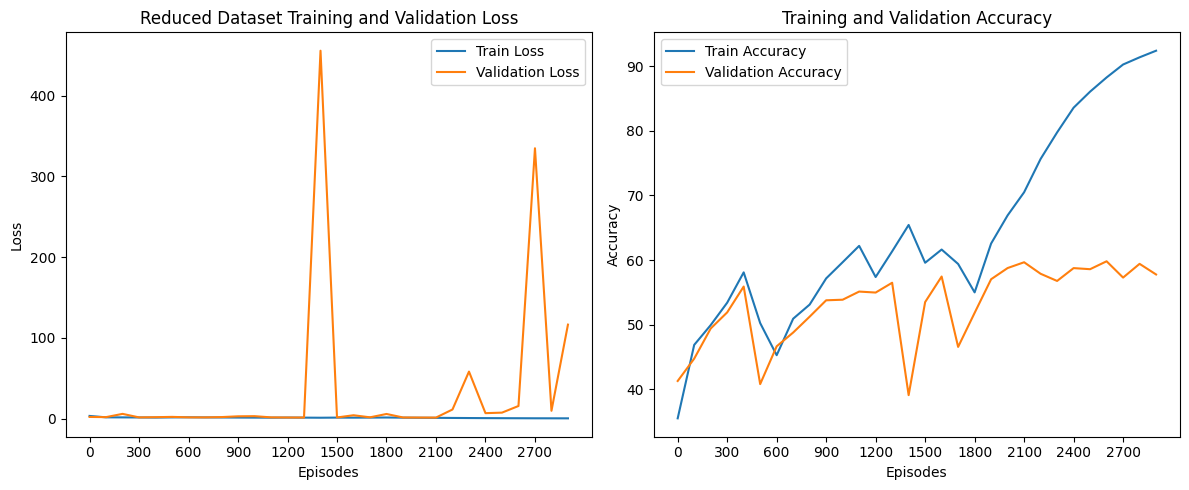

In [66]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
epochs = range(len(train_losses))
plt.plot(epochs, reduced2_train_losses, label="Train Loss")
plt.plot(epochs, reduced2_val_losses, label="Validation Loss")
plt.xticks(epochs[::len(epochs)//10], [int(x*100) for x in epochs[::len(epochs)//10]])  # Multiply x labels by 100
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.title("Reduced Dataset Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, reduced2_train_accuracies, label="Train Accuracy")
plt.plot(epochs, reduced2_val_accuracies, label="Validation Accuracy")
plt.xticks(epochs[::len(epochs)//10], [int(x*100) for x in epochs[::len(epochs)//10]])  # Multiply x labels by 100
plt.xlabel("Episodes")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

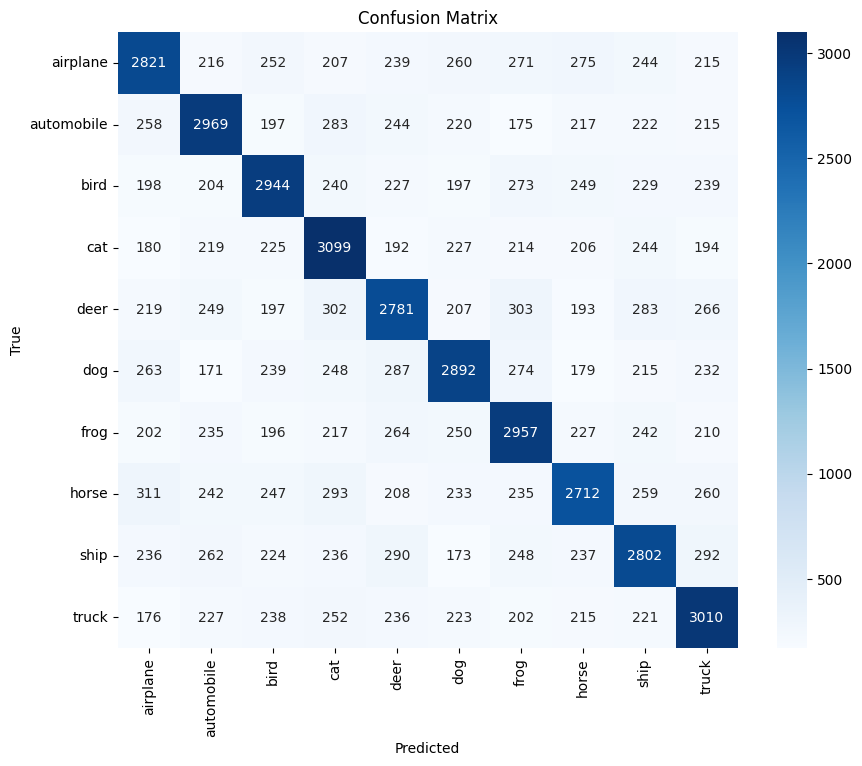

In [69]:
plot_confusion_matrix(reduced2_test_targets, reduced2_test_predictions, class_names)

In [70]:
torch.save(model.state_dict(), "reduced2_fewshot_densenet121_model.pth")

In [71]:
files.download("reduced2_fewshot_densenet121_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [80]:
all_batches = range(1, len(train_losses) + 1)
all_batches_episodes = [episode * 100 for episode in all_batches]

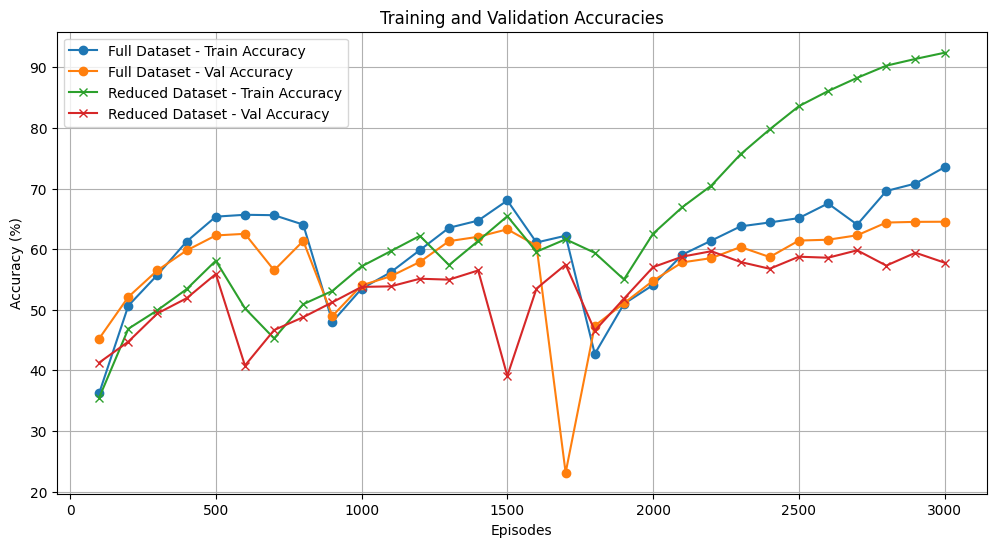

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(all_batches_episodes, train_accuracies, label='Full Dataset - Train Accuracy', marker='o')
plt.plot(all_batches_episodes, val_accuracies, label='Full Dataset - Val Accuracy', marker='o')
plt.plot(all_batches_episodes, reduced2_train_accuracies, label='Reduced Dataset - Train Accuracy', marker='x')
plt.plot(all_batches_episodes, reduced2_val_accuracies, label='Reduced Dataset - Val Accuracy', marker='x')
plt.title('Training and Validation Accuracies')
plt.xlabel('Episodes')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
labels = ['Full Dataset', 'Reduced Dataset']
test_losses = [test_loss, reduced2_test_loss]
test_accuracies = [test_acc, reduced2_test_acc]

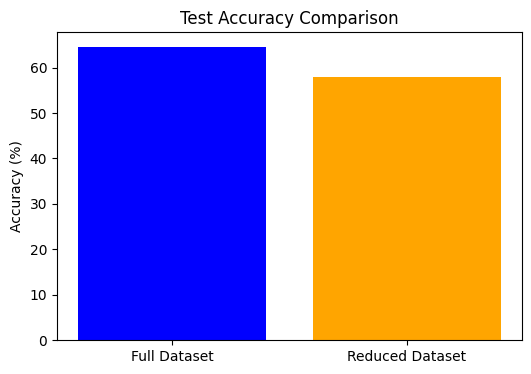

In [84]:
plt.figure(figsize=(6, 4))
plt.bar(labels, test_accuracies, color=['blue', 'orange'])
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.show()